In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Задания (содержание)

Продакт-менеджер попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

# Данные

In [3]:
df_customers = pd.read_csv('/content/drive/MyDrive/Analytics e-commerce/olist_customers_dataset.csv')
df_order_items = pd.read_csv('/content/drive/MyDrive/Analytics e-commerce/olist_order_items_dataset.csv')
df_orders = pd.read_csv('/content/drive/MyDrive/Analytics e-commerce/olist_orders_dataset.csv')

## Описание данных (+ ссылки)

**[olist_customers_datase.csv](https://drive.google.com/file/d/15-hLXTbsANqqre8KWdpnqpbihcS-17_C/view?usp=sharing) — таблица с уникальными идентификаторами пользователей**

* customer_id — позаказный идентификатор пользователя

* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

* customer_zip_code_prefix —  почтовый индекс пользователя

* customer_city —  город доставки пользователя

* customer_state —  штат доставки пользователя

**[olist_orders_dataset.csv](https://drive.google.com/file/d/1NcG8o7dOq-x-6igjdFr7yTMg7VzbKRux/view?usp=sharing) —  таблица заказов**

* order_id —  уникальный идентификатор заказа (номер чека)

* customer_id —  позаказный идентификатор пользователя

* order_status —  статус заказа

* order_purchase_timestamp —  время создания заказа

* order_approved_at —  время подтверждения оплаты заказа

* order_delivered_carrier_date —  время передачи заказа в логистическую службу

* order_delivered_customer_date —  время доставки заказа

* order_estimated_delivery_date —  обещанная дата доставки

**[olist_order_items_dataset.csv](https://drive.google.com/file/d/1ttItZ6XmhOTz58lcNmXf2eV0HxKa9Jth/view?usp=sharing) —  товарные позиции, входящие в заказы**

* order_id —  уникальный идентификатор заказа (номер чека)

* order_item_id —  идентификатор товара внутри одного заказа

* product_id —  ид товара (аналог штрихкода)

* seller_id — ид производителя товара

* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

* price —  цена за единицу товара

* freight_value —  вес товара

****

**Уникальные статусы заказов в таблице olist_orders_dataset:**

* created —  создан

* approved —  подтверждён

* invoiced —  выставлен счёт

* processing —  в процессе сборки заказа

* shipped —  отгружен со склада

* delivered —  доставлен пользователю

* unavailable —  недоступен

* canceled —  отменён

# Предварительное исследование данных

## 1. df_customers — уникальные идентификаторы пользователей

In [4]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
df_customers.shape

(99441, 5)

In [6]:
df_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
df_customers.duplicated().sum()

0

## 2. df_order_items — товарные позиции, входящие в заказы

In [9]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
df_order_items.shape

(112650, 7)

In [11]:
df_order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [12]:
df_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [13]:
df_order_items.duplicated().sum()

0

**Надо конвертировать столбец** ``shipping_limit_date`` **в формат даты**

In [14]:
df_order_items['shipping_limit_date'] = pd.to_datetime(df_order_items['shipping_limit_date'])

## 3. df_orders — таблица заказов

In [15]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [16]:
df_orders.shape

(99441, 8)

In [17]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [18]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [19]:
df_orders.duplicated().sum()

0

**Надо конвертировать столбцы** ``order_purchase_timestamp``, ``order_approved_at``, ``order_delivered_carrier_date``, ``order_delivered_customer_date``, ``order_estimated_delivery_date`` **в формат даты**

In [20]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_approved_at'] = pd.to_datetime(df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders['order_estimated_delivery_date'])

**Посмотрим на распределение статусов заказов**

In [21]:
df_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

**Что считаем покупкой?**

In [22]:
df_orders.sort_values('order_approved_at').tail() # некоторые оплаты заказов не подтверждены
df_orders.query('order_approved_at == "NaT"').groupby('order_status', as_index=False).agg({'order_id': 'count'})

,order_status,order_id
0,canceled,141
1,created,5
2,delivered,14


**Будем считать покупкой те заказы, где:**
1. ``order_approved_at`` != `NaT`
2. ``order_status`` != ``unavailable``, ``canceled``

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

**Подготовим датафрейм**

In [23]:
# Объединили датафрэймы с заказами (df_orders) и информацией о клиентах (df_customers)
df_one_purchase = df_orders.merge(df_customers, on='customer_id')

# Оставим только те заказы, которые ранее были обозначены как покупка
df_one_purchase = df_one_purchase.query('order_approved_at !="NaT"')
df_one_purchase = df_one_purchase.loc[(df_one_purchase.order_status != 'unavailable') & (df_one_purchase.order_status != 'canceled')]

df_one_purchase.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


**Группировка**

In [24]:
# Сгруппировали по уникальному id пользователя (customer_unique_id) и посчитаем кол-во id заказов (order_id)
df_one_purchase = df_one_purchase.groupby('customer_unique_id', as_index=False) \
.agg({'order_id': 'count'}).sort_values('order_id')

## Вывод

In [25]:
# Отберем пользователей, которые совершили покупку только один раз
df_one_purchase = df_one_purchase.query('order_id == 1')

print(f'Кол-во пользователей, совершивших покупку только 1 раз: {len(df_one_purchase.customer_unique_id.unique())}')

Кол-во пользователей, совершивших покупку только 1 раз: 92087


# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

У нас есть всего 2 причины из-за которых заказ может быть не доставлен:

* Заказ отменён: ``order_status == canceled``
* Заказ недоступен: ``order_status == unavailable``

Остальные ``order_status`` не будем считать за недоставленные заказы, так как они не были отменены, а следовательно могут быть доставлены позже

**Подготовим датафрейм**

In [26]:
# Оставим только те заказы, где статус заказа = отменен или недоступен
not_delivered_df = df_orders.loc[(df_orders.order_status == 'canceled') | (df_orders.order_status == 'unavailable')]

# Дополнительно, чтобы избежать багов, оставим только те заказы, где время доставки неуказано (т. е. товар не был доставлен)
not_delivered_df = not_delivered_df.query('order_delivered_customer_date == "NaN"')

# Создадим столбец с годом и месяцем создания заказа
not_delivered_df['order_purchase_month'] = not_delivered_df.order_purchase_timestamp.dt.strftime('%Y-%m')

not_delivered_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,2017-11
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,2018-01
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-01
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,2017-08


**Группировка**

In [27]:
# Сгруппируем данные по месяцам и статусам заказов, а затем посчитаем кол-во недоставленных заказов
not_delivered_df = not_delivered_df.groupby(['order_purchase_month', 'order_status'], as_index=False) \
  .agg({'order_id': 'count'}).sort_values(['order_purchase_month', 'order_status']) \
  .rename(columns={'order_id': 'num_of_orders'})

not_delivered_df.head()

,order_purchase_month,order_status,num_of_orders
0,2016-09,canceled,2
1,2016-10,canceled,19
2,2016-10,unavailable,7
3,2017-01,canceled,3
4,2017-01,unavailable,10


**Сводная таблица**

In [28]:
# Создадим сводную таблицу и посчитаем сумму всех недоставленных заказов для каждого месяца
not_delivered_df_pivot = not_delivered_df.pivot(index='order_purchase_month', columns='order_status', values='num_of_orders')
not_delivered_df_pivot['sum_orders'] = not_delivered_df_pivot.canceled + not_delivered_df_pivot.unavailable

not_delivered_df_pivot.head()

order_status,canceled,unavailable,sum_orders
order_purchase_month,,,
2016-09,2.0,NaN,NaN
2016-10,19.0,7.0,26.0
2017-01,3.0,10.0,13.0
2017-02,17.0,45.0,62.0
2017-03,33.0,32.0,65.0


**Визуализация**

Text(0, 0.5, 'Кол-во недоставленных заказов')

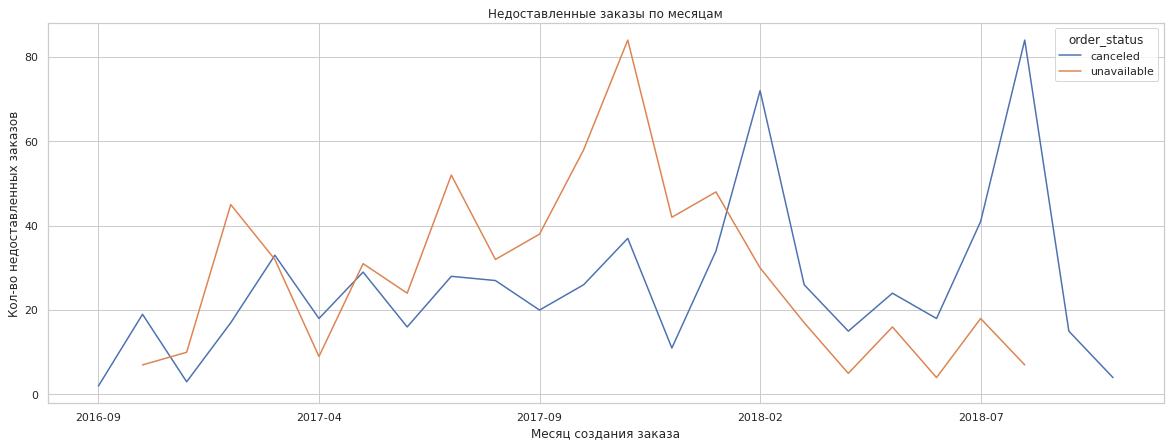

In [29]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

not_delivered_df_pivot[['canceled', 'unavailable']].plot()
plt.title('Недоставленные заказы по месяцам')
plt.xlabel('Месяц создания заказа')
plt.ylabel('Кол-во недоставленных заказов')

## Вывод

In [30]:
canceled = not_delivered_df_pivot.canceled.mean()
unavailable = not_delivered_df_pivot.unavailable.mean()
sum_orders = not_delivered_df_pivot.sum_orders.mean()

print(f'Среднее кол-во недоставленных заказов (по всем причинам): {round(not_delivered_df_pivot.sum_orders.mean())}')
print(f'Среднее кол-во отмененных заказов: {round(not_delivered_df_pivot.canceled.mean())}')
print(f'Среднее кол-во недоступных заказов: {round(not_delivered_df_pivot.unavailable.mean())}')

Среднее кол-во недоставленных заказов (по всем причинам): 57
Среднее кол-во отмененных заказов: 26
Среднее кол-во недоступных заказов: 29


# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

**Подготовим датафрейм**

In [31]:
# Объединим df с описанием товарных позиций (df_order_items) с df описанием заказов (df_orders)
products_by_day_df = df_order_items.merge(df_orders, on='order_id')

# Оставим только те заказы, которые ранее были обозначены как покупка
products_by_day_df = products_by_day_df.query('order_approved_at !="NaT"')
products_by_day_df = products_by_day_df.loc[(products_by_day_df.order_status != 'unavailable') & (products_by_day_df.order_status != 'canceled')]

# Создадим столбец с с названиями дней недели
products_by_day_df['week_day_name'] = products_by_day_df.order_purchase_timestamp.dt.day_name()

products_by_day_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,week_day_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday


**Группировка**

In [32]:
# Сгруппируем данные по product_id и дню недели, а затем посчитаем кол-во сделанных заказов
products_by_day_df = products_by_day_df.groupby(['product_id', 'week_day_name'], as_index=False) \
  .agg({'order_item_id': 'count'}) \
  .rename(columns={'order_item_id': 'num_of_orders'}) \
  .sort_values('num_of_orders', ascending=False)

products_by_day_df.head()

,product_id,week_day_name,num_of_orders
15812,422879e10f46682990de24d770e7f83d,Wednesday,93
36305,99a4788cb24856965c36a24e339b6058,Monday,92
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40815,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40820,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


**Сводная таблица**

In [33]:
products_by_day_df_pivot = products_by_day_df.pivot(index='product_id', columns='week_day_name', values='num_of_orders').fillna(0)

products_by_day_df_pivot.head()

week_day_name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0009406fd7479715e4bef61dd91f2462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Вывод

**Определим в какой день недели товар чаще всего покупается**

In [34]:
products_by_best_day_df = products_by_day_df_pivot.idxmax(axis=1).to_frame().rename(columns={0: 'day_of_week'}).reset_index()
products_by_best_day_df.head()

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


**Визуализация**

Text(0, 0.5, 'Кол-во product_id')

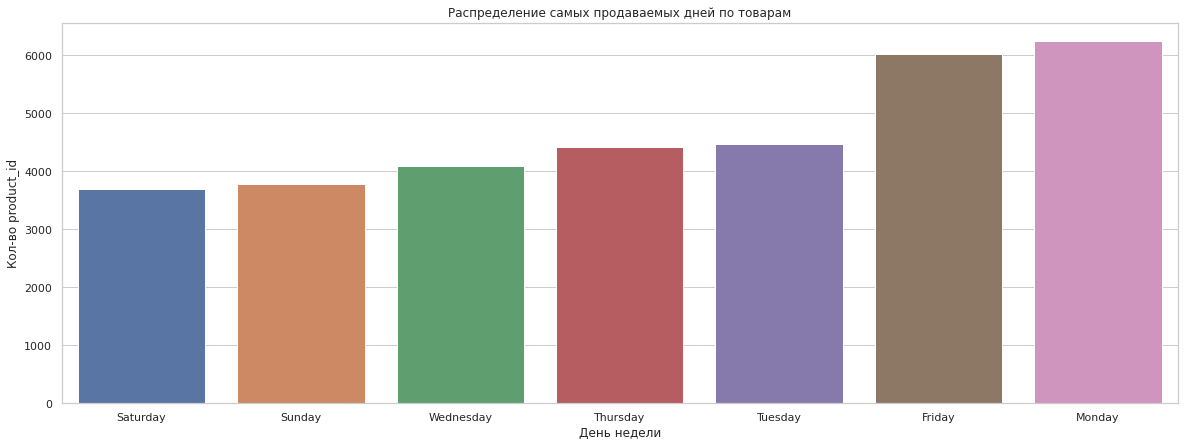

In [35]:
products_by_best_day_df_visual = products_by_best_day_df.groupby('day_of_week', as_index=False) \
  .agg({'product_id': 'count'}).rename(columns={'product_id': 'num_of_products'}).sort_values('num_of_products')

sns.barplot(x='day_of_week', y='num_of_products', data=products_by_best_day_df_visual)
plt.title('Распределение самых продаваемых дней по товарам')
plt.xlabel('День недели')
plt.ylabel('Кол-во product_id')

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

**Подготовим датафрейм**

In [36]:
orders_by_week_df = df_customers.merge(df_orders, on="customer_id")

# Оставим только те заказы, которые ранее были обозначены как покупка
orders_by_week_df = orders_by_week_df.query('order_approved_at !="NaT"')
orders_by_week_df = orders_by_week_df.loc[(orders_by_week_df.order_status != 'unavailable') & (orders_by_week_df.order_status != 'canceled')]

# Создадим столбец с годом и месяцем создания заказа
orders_by_week_df['order_purchase_month'] = orders_by_week_df.order_purchase_timestamp.dt.strftime('%Y-%m')

orders_by_week_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07


**Посмотрим диапазон дат**

In [37]:
print(f'Min date: {orders_by_week_df.order_purchase_timestamp.min()}\nMax date: {orders_by_week_df.order_purchase_timestamp.max()}')

Min date: 2016-09-04 21:15:19
Max date: 2018-09-03 09:06:57


Так как наши данные содержат неполные месяцы, то возьмем только полные месяцы для правильного подсчета недель

In [38]:
orders_by_week_df = orders_by_week_df.query('order_purchase_timestamp >= "2016-10-01" & order_purchase_timestamp < "2018-09-01"')

**Группировка**

In [39]:
orders_by_week_df = orders_by_week_df.groupby(['customer_unique_id', 'order_purchase_month']) \
  .agg({'order_id': 'count'}).sort_values('order_purchase_month') \
  .reset_index().rename(columns={'order_id': 'num_of_orders'})

# Создадим столбец, где будет подсчитано среднее кол-во покупок в неделю в каждом месяце для каждого пользователя (формула ниже)
orders_by_week_df['num_of_orders_by_week'] = orders_by_week_df.num_of_orders / (pd.to_datetime(orders_by_week_df.order_purchase_month).dt.daysinmonth / 7)

orders_by_week_df.head()

,customer_unique_id,order_purchase_month,num_of_orders,num_of_orders_by_week
0,f176923a0a4ab546c7287791ccb82193,2016-10,1,0.225806
1,c2154b6ca788852f644e6f56dc7abbe9,2016-10,1,0.225806
2,de51ac050e580a6f05fdf0d56fac2cef,2016-10,1,0.225806
3,27ede105a6042b71a261bf57f75fdcf8,2016-10,1,0.225806
4,1151be76113653dc4ed5d7e7fd17763a,2016-10,1,0.225806


$$Среднее\space количество\space покупок\space в\space неделю = \frac{Количество\space покупок\space за\space месяц}{Количество\space дней\space в\space месяце / 7}$$

## Вывод

**Найдём среднее количество покупок в неделю для каждого пользователя**

In [40]:
orders_by_week_df_final = orders_by_week_df.groupby('customer_unique_id', as_index=False) \
  .agg({'num_of_orders_by_week': 'mean'}).rename(columns={'num_of_orders_by_week': 'mean_num_of_orders_by_week'})

orders_by_week_df_final.head()

,customer_unique_id,mean_num_of_orders_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333


**Общее среднее количество покупок в неделю для всех пользователей**

In [41]:
orders_by_week_df_final.mean_num_of_orders_by_week.mean()

0.2332364696765196

**Визуализация**

Text(0, 0.5, 'Ср. кол-во заказов на пользователя в неделю')

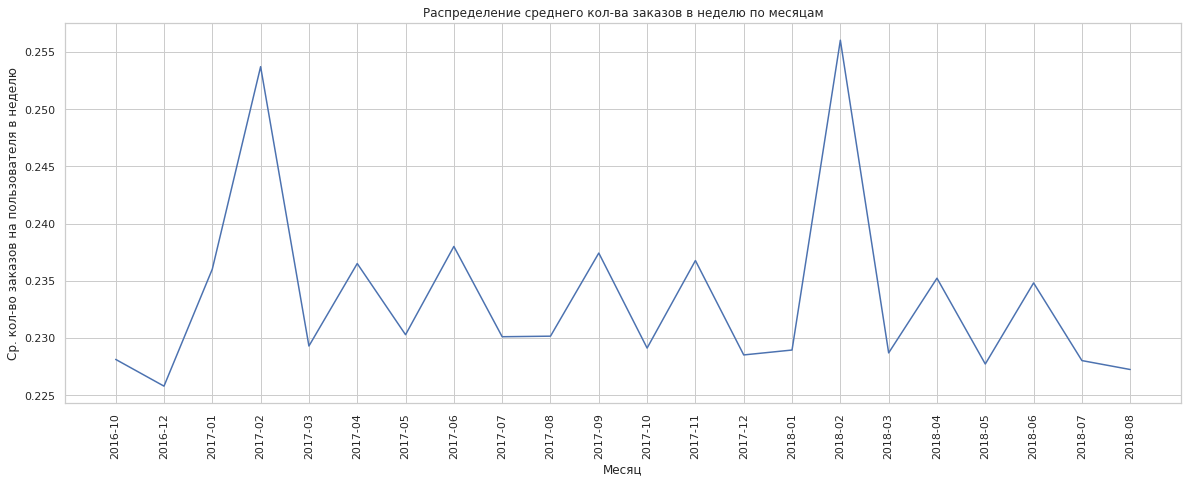

In [42]:
orders_by_week_df_visual = orders_by_week_df.groupby('order_purchase_month') \
  .agg({'num_of_orders_by_week': 'mean'}) \
  .sort_values('order_purchase_month').reset_index()

sns.lineplot(x='order_purchase_month', y='num_of_orders_by_week', data=orders_by_week_df_visual)
plt.xticks(rotation=90)
plt.title('Распределение среднего кол-ва заказов в неделю по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Ср. кол-во заказов на пользователя в неделю')

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

**Определим диапазон дат**

In [77]:
print(f'Первая дата покупки: {df_orders.order_approved_at.min()}\n\
Последняя дата покупки: {df_orders.order_approved_at.max()}')

Первая дата покупки: 2016-09-15 12:16:38
Последняя дата покупки: 2018-09-03 17:40:06


У нас представлены данные с 2016 по 2018 годы, но при этом лишь 2017 год является полным. 

Так как по условию задачи необходимо провести когортный анализ в период с января по декабрь, то для исследования возьмем период с начала 2017 года и добавим 3 месяца из 2018 (чтобы оценить когорту 2017-12-31).

In [78]:
min_date = '2017-01-01'
max_date = '2018-04-01'

**Подготовим датафрейм**

In [79]:
# Объединим датафрэймы с уникальными id пользователей и заказами в один
df_full =  df_customers.merge(df_orders, on='customer_id')

# Зададим нужный диапазон дат
df_full = df_full.query('order_approved_at >= @min_date and order_approved_at <= @max_date')

# Оставим только те заказы, которые ранее были обозначены как покупка
df_full = df_full.query('order_approved_at !="NaT"')
df_full = df_full.loc[(df_full.order_status != 'unavailable') & (df_full.order_status != 'canceled')]

# Создадим столбец с годом и месяцем создания заказа
df_full['order_purchase_month'] = df_full.order_purchase_timestamp.dt.strftime('%Y-%m')

df_full.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,2018-02-20 16:25:51,2018-03-05,2018-02


## Найдём дату первой покупки для каждого покупателя

In [80]:
df_first_order = df_full.groupby('customer_unique_id', as_index=False) \
  .agg({'order_purchase_month': 'min'}).sort_values('customer_unique_id') \
  .rename(columns={'order_purchase_month': 'first_order_month'})

df_first_order.head()

,customer_unique_id,first_order_month
0,0000f46a3911fa3c0805444483337064,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11
3,00053a61a98854899e70ed204dd4bafe,2018-02
4,0005e1862207bf6ccc02e4228effd9a0,2017-03


## Строим когорты

In [81]:
cohorts_df = df_full[['customer_unique_id', 'order_id', 'order_purchase_month']].merge(df_first_order, on='customer_unique_id')

cohorts_df = cohorts_df.groupby(['first_order_month', 'order_purchase_month']) \
  .agg({'customer_unique_id': 'nunique'}).rename(columns={'customer_unique_id': 'num_of_users'})

cohorts_df.head()

num_of_users
first_order_month order_purchase_month              
2017-01           2017-01                        751
                  2017-02                          3
                  2017-03                          2
                  2017-04                          1
                  2017-05                          3

In [82]:
# Функция, которая нумерует месяцы по диапазону окна в когорте
def cohort_month(df):
    df['month'] = np.arange(len(df))
    return df

cohorts_df = cohorts_df.groupby('first_order_month').apply(cohort_month)

cohorts_df.tail()

num_of_users  month
first_order_month order_purchase_month                     
2018-01           2018-02                         23      1
                  2018-03                         25      2
2018-02           2018-02                       6356      0
                  2018-03                         22      1
2018-03           2018-03                       6859      0

In [83]:
# Заменим индексы
cohorts_df.reset_index(inplace=True)
cohorts_df.set_index(['first_order_month', 'month'], inplace=True)

cohorts_df.head()

order_purchase_month  num_of_users
first_order_month month                                   
2017-01           0                  2017-01           751
                  1                  2017-02             3
                  2                  2017-03             2
                  3                  2017-04             1
                  4                  2017-05             3

In [84]:
# Сохраним размеры когорт
cohort_size_df = cohorts_df['num_of_users'].groupby('first_order_month').first()

cohort_size_df.head()

first_order_month
2017-01     751
2017-02    1678
2017-03    2571
2017-04    2326
2017-05    3541
Name: num_of_users, dtype: int64

## Таблица с retention

In [85]:
retention_df = cohorts_df['num_of_users'].unstack('first_order_month').T.divide(cohort_size_df, axis=0)

retention_df.head()

month,0,1,2,3,4,5,6,7,8,9,10,11,12,13
first_order_month,,,,,,,,,,,,,,
2017-01,1.0,0.003995,0.002663,0.001332,0.003995,0.001332,0.003995,0.001332,0.001332,0.003995,0.001332,0.006658,0.003995,0.001332
2017-02,1.0,0.002384,0.002980,0.001192,0.004172,0.001192,0.002384,0.001788,0.000596,0.001788,0.001192,0.002980,0.001192,0.001788
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,NaN
2017-04,1.0,0.006019,0.002150,0.001720,0.003009,0.002580,0.003439,0.003009,0.003009,0.001720,0.002580,0.000860,NaN,NaN
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,NaN,NaN,NaN


Text(0.5, 39.5, 'Номер месяца')

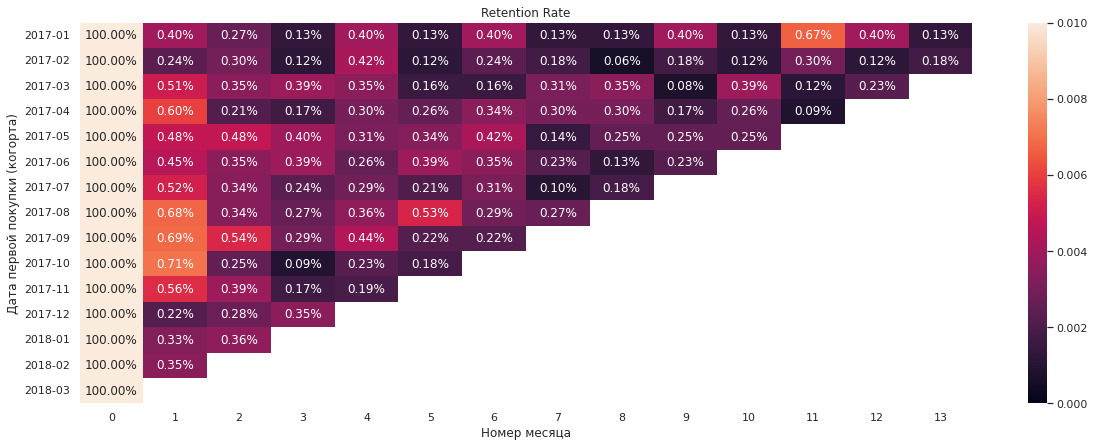

In [86]:
sns.heatmap(retention_df, mask=retention_df.isnull(), annot=True, fmt='.2%', vmin=0.0, vmax=0.01)
plt.title('Retention Rate')
plt.ylabel('Дата первой покупки (когорта)')
plt.xlabel('Номер месяца')

## Вывод

Таким образом, в период с января по декабрь когорта "2017-05" имеет самый высокий retention на 3-й месяц

# 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

В кластеризации можешь выбрать следующие метрики: 
 - R — время от последней покупки пользователя до текущей даты,
 - F — суммарное количество покупок у пользователя за всё время,
 - M — сумма покупок за всё время.
 
Подробно опиши, как ты создавал кластеры.

**Подготовим датафрейм**

In [98]:
# Объединим все датафрэймы в один
rfm_df = df_orders.merge(df_customers, on='customer_id').merge(df_order_items, on='order_id')

# Оставим только те заказы, которые ранее были обозначены как покупка
rfm_df = rfm_df.query('order_approved_at !="NaT"')
rfm_df = rfm_df.loc[(rfm_df.order_status != 'unavailable') & (rfm_df.order_status != 'canceled')]

rfm_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [99]:
print(f'Первая дата покупки:     {min(rfm_df.order_approved_at)}\n\
Последняя дата покупки:  {max(rfm_df.order_approved_at)}')

Первая дата покупки:     2016-09-15 12:16:38
Последняя дата покупки:  2018-09-03 17:40:06


Так как данные старые, то логично в целях данного задания за текущую дату взять последнюю дату покупки.

In [100]:
# Сохраним эту дату в переменную
todays_date = pd.to_datetime('2018-09-03 17:40:06')

**Группировка**

In [101]:
# Оставим информацию о id заказа, датах оплаты, id покупателя и посчитаем общую стоимость каждого заказа
rfm_df = rfm_df.groupby(['order_id', 'order_approved_at', 'customer_unique_id'], as_index=False) \
  .agg({'price': 'sum'}).sort_values('order_approved_at').rename(columns={'price': 'money'})

rfm_df.head()

,order_id,order_approved_at,customer_unique_id,money
73486,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,830d5b7aaa3b6f1e9ad63703bec97d23,134.97
12230,1ff217aa612f6cd7c4255c9bfe931c8b,2016-10-04 09:43:32,14359ea0c7a105749c0a56478825b015,32.49
78706,cd3b8574c82b42fc8129f6d502690c3e,2016-10-04 10:19:23,87776adb449c551e74c13fc34f036105,29.99
91134,ed8c7b1b3eb256c70ce0c74231e1da88,2016-10-04 10:25:46,88bc832f104b6dd684a17dbb1b76e778,89.90
80623,d207cc272675637bfed0062edffd0818,2016-10-04 10:28:07,8d3a54507421dbd2ce0a1d58046826e0,119.90


## Посчитаем нужные показатели для RFM

 1. R — время от последней покупки пользователя до текущей даты
 2. F — суммарное количество покупок у пользователя за всё время
 3. M — сумма покупок за всё время

In [102]:
# Для каждого пользователя найдем последнюю дату покупки, кол-во заказов и их стоимость
rfm_df = rfm_df.groupby('customer_unique_id', as_index=False) \
  .agg({'order_approved_at': 'max', 'order_id': 'count', 'money': 'sum'})

# Найдем разницу между временем от последней покупки до текущей даты (todays_date == '2018-09-03 09:06:57')
rfm_df['order_approved_at'] = todays_date - rfm_df.order_approved_at

# Переименуем колонки для удобства
rfm_df = rfm_df.rename(columns={'order_approved_at': 'recency', 'order_id': 'frequency', 'money': 'monetary'})

rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116 days 06:28:48,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 23:14:22,1,18.90
2,0000f46a3911fa3c0805444483337064,541 days 20:35:03,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325 days 20:50:49,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292 days 21:33:14,1,180.00


## Изучим полученные показатели и составим границы метрик

In [103]:
rfm_df.describe()

,recency,frequency,monetary
count,94970,94970.000000,94970.000000
mean,242 days 23:01:01.904569864,1.033853,142.073605
std,152 days 22:54:24.354354938,0.210801,216.085833
min,0 days 00:00:00,1.000000,0.850000
25%,118 days 22:24:45.250000,1.000000,47.900000
50%,223 days 17:47:00.500000,1.000000,89.890000
75%,351 days 23:55:40.500000,1.000000,155.000000
max,718 days 05:23:28,16.000000,13440.000000


Составим 4 границы для каждого из показателей rfm

**Recency**

4 границы Recency будут основываться на значениях 25, 50 и 75 перцентилей

Чем меньше количество дней, тем выше будет ранг

In [133]:
r_q25 = rfm_df.recency.quantile(0.25)
r_q50 = rfm_df.recency.quantile(0.5)
r_q75 = rfm_df.recency.quantile(0.75)

def find_recency(col):
  if col < r_q25:
    return 4
  elif col >= r_q25 and col < r_q50:
    return 3
  elif col >= r_q50 and col < r_q75:
    return 2
  elif col >= r_q75:
    return 1

In [135]:
rfm_df['r'] = rfm_df.recency.apply(lambda x: find_recency(x))
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r
0,0000366f3b9a7992bf8c76cfdf3221e2,116 days 06:28:48,1,129.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 23:14:22,1,18.90,3
2,0000f46a3911fa3c0805444483337064,541 days 20:35:03,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,325 days 20:50:49,1,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,292 days 21:33:14,1,180.00,2


**Frequency**

In [138]:
rfm_df.frequency.value_counts()

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: frequency, dtype: int64

Так как абсолютное большинство клиентов совершило лишь 1 покупку, а разбивать frequency мы планируем на 4 границы, то возьмем клиентов, совершивших:

* 1 покупку
* 2 покупки
* 3 покупки
* 4 и более покупок

Чем больше количество покупок, тем выше будет ранг

In [139]:
def find_frequency(col):
  if col == 1:
    return 1
  elif col == 2:
    return 2
  elif col == 3:
    return 3
  elif col > 3:
    return 4

In [140]:
rfm_df['f'] = rfm_df.frequency.apply(lambda x: find_frequency(x))
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r,f
0,0000366f3b9a7992bf8c76cfdf3221e2,116 days 06:28:48,1,129.90,4,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 23:14:22,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,541 days 20:35:03,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,325 days 20:50:49,1,25.99,2,1
4,0004aac84e0df4da2b147fca70cf8255,292 days 21:33:14,1,180.00,2,1


In [150]:
rfm_df.f.value_counts()

1    92084
2     2650
3      188
4       48
Name: f, dtype: int64

**Monetary**

Распределение значений monetary так же, как и для frequency, сильно отколняются от нормального распределения

<AxesSubplot:xlabel='monetary', ylabel='Density'>

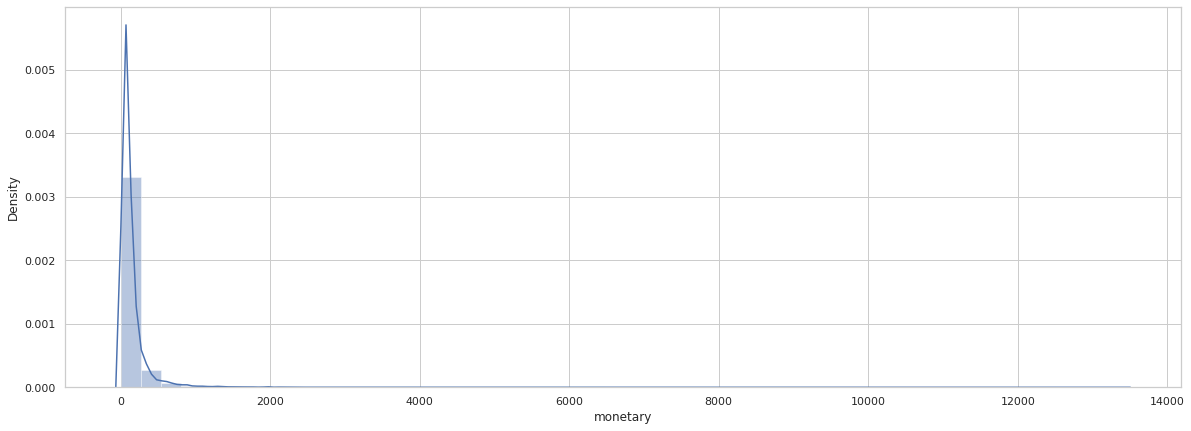

In [170]:
sns.distplot(rfm_df.monetary)

In [152]:
rfm_df.loc[rfm_df.monetary > rfm_df.monetary.quantile(0.75)].monetary.describe()

count    23687.000000
mean       356.092095
std        348.642628
min        155.060000
25%        189.880000
50%        244.990000
75%        371.850000
max      13440.000000
Name: monetary, dtype: float64

In [162]:
rfm_df.loc[rfm_df.monetary > 371.850000].monetary.describe()

count     5922.000000
mean       742.280854
std        526.503220
min        372.000000
25%        445.267500
50%        586.780000
75%        829.742500
max      13440.000000
Name: monetary, dtype: float64

In [163]:
rfm_df.loc[rfm_df.monetary > 829.742500].monetary.describe()

count     1481.000000
mean      1371.213153
std        730.634350
min        829.990000
25%        949.990000
50%       1180.000000
75%       1559.920000
max      13440.000000
Name: monetary, dtype: float64

Так как по сравнению с 1 рангом frequency остальные ранги вышли крайне малочисленными, то для каждой границы показателя monetary я буду брать значения до 75 перцентиля, затем отсекать данные (больше 75 перцентиля) и снова возьму значения до 75 перцентиля (всего 3 раза)

Чем больше сумма покупок, тем выше будет ранг

In [178]:
m_q75_1 = rfm_df.monetary.quantile(0.75)
m_q75_2 = rfm_df.loc[rfm_df.monetary > m_q75_1].monetary.quantile(0.75)
m_q75_3 = rfm_df.loc[rfm_df.monetary > m_q75_2].monetary.quantile(0.75)
print(f'{m_q75_1}\n{m_q75_2}\n{m_q75_3}')

155.0
371.85
829.7425000000001


In [181]:
def find_monetary(col):
  if col < m_q75_1:
    return 4
  elif col >= m_q75_1 and col < m_q75_2:
    return 3
  elif col >= m_q75_2 and col < m_q75_3:
    return 2
  elif col >= m_q75_3:
    return 1

In [182]:
rfm_df['m'] = rfm_df.monetary.apply(lambda x: find_monetary(x))
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r,f,m
0,0000366f3b9a7992bf8c76cfdf3221e2,116 days 06:28:48,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 23:14:22,1,18.90,3,1,4
2,0000f46a3911fa3c0805444483337064,541 days 20:35:03,1,69.00,1,1,4
3,0000f6ccb0745a6a4b88665a16c9f078,325 days 20:50:49,1,25.99,2,1,4
4,0004aac84e0df4da2b147fca70cf8255,292 days 21:33:14,1,180.00,2,1,3


**Итог по границам метрик**

In [216]:
r_value_counts =  rfm_df.r.value_counts().to_frame().reset_index()
m_value_counts =  rfm_df.m.value_counts().to_frame().reset_index()
f_value_counts =  rfm_df.f.value_counts().to_frame().reset_index()

rmf_value_counts = r_value_counts.merge(f_value_counts, on='index').merge(m_value_counts, on='index') \
  .sort_values('index')

rmf_value_counts

,index,r,f,m
1,1,23743,92084,1481
3,2,23742,2650,4441
2,3,23742,188,17839
0,4,23743,48,71209


## Добавим сегменты на основании полученных r, f, m оценок

## Добавим rfm_score на основании полученных r, f, m оценок


In [196]:
rfm_df['rfm_score'] = rfm_df['r'].map(str) + rfm_df['f'].map(str) + rfm_df['m'].map(str)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116 days 06:28:48,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118 days 23:14:22,1,18.90,3,1,4,314
2,0000f46a3911fa3c0805444483337064,541 days 20:35:03,1,69.00,1,1,4,114
3,0000f6ccb0745a6a4b88665a16c9f078,325 days 20:50:49,1,25.99,2,1,4,214
4,0004aac84e0df4da2b147fca70cf8255,292 days 21:33:14,1,180.00,2,1,3,213


In [197]:
rfm_df.rfm_score.nunique()

58

**Получилось 58 уникальных сегментов (макисмальное кол-во может быть 64)**

При составлении названий RFM-сегментов я буду основываться в первую очередь на метрике monetary, а только потом на recency и frequency

Сегмент «Эконом»:

* 411 — новые клиенты
* 421 — вернувшиеся клиенты
* 431/441 — лояльные клиенты

* 311/211 — спящие новые клиенты
* 321/221 — спящие вернувшиеся клиенты
* 331/341/231/241 — спящие лояльные клиенты

* 111 — потерянные новые клиенты
* 121 — потерянные вернувшиеся клиенты
* 131/141 — потерянные лояльные клиенты

Сегмент «Средний»:

* 412/413 — новые клиенты
* 422/423 — вернувшиеся клиенты
* 432/433/442/443 — лояльные клиенты


* 312/313/212/213 — спящие новые клиенты
* 322/323/222/223 — спящие вернувшиеся клиенты
* 332/333/342/343/232/233/242/243 — спящие лояльные клиенты


* 112/113 — потерянные новые клиенты
* 122/123 — потерянные вернувшиеся клиенты
* 132/133/142/143 — потерянные лояльные клиенты

Сегмент «Премиум»:

* 414 — новые клиенты
* 424 — вернувшиеся клиенты
* 434/444 — лояльные клиенты

* 314/214 — спящие новые клиенты
* 324/224 — спящие вернувшиеся клиенты
* 334/344/234/244 — спящие лояльные клиенты

* 114 — потерянные новые клиенты
* 124 — потерянные вернувшиеся клиенты
* 134/144 — потерянные лояльные клиенты


_**Пояснение:** RFM-сегмент 414 будет называться "Премиум новые клиенты", под номером 312 — "Средний спящие клиенты" и т. д._

**Визуализируем размеры сегментов**

Text(0, 0.5, 'Кол-во клиентов')

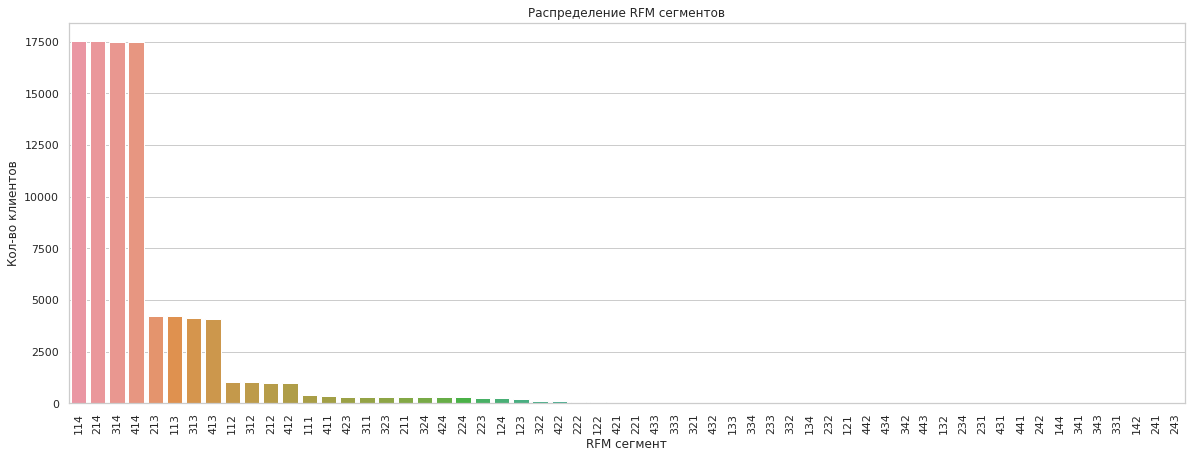

In [215]:
rfm_score_value_counts = rfm_df.rfm_score.value_counts().to_frame().reset_index() \
  .rename(columns={'rfm_score': 'num_of_people', 'index': 'rfm_score'}) \
  .sort_values('num_of_people', ascending=False)

sns.barplot(data=rfm_score_value_counts, x='rfm_score', y='num_of_people')
plt.xticks(rotation=90)
plt.title('Распределение RFM сегментов')
plt.xlabel('RFM сегмент')
plt.ylabel('Кол-во клиентов')

**Визуализируем доходность сегментов**

Text(0, 0.5, 'Сумма покупок')

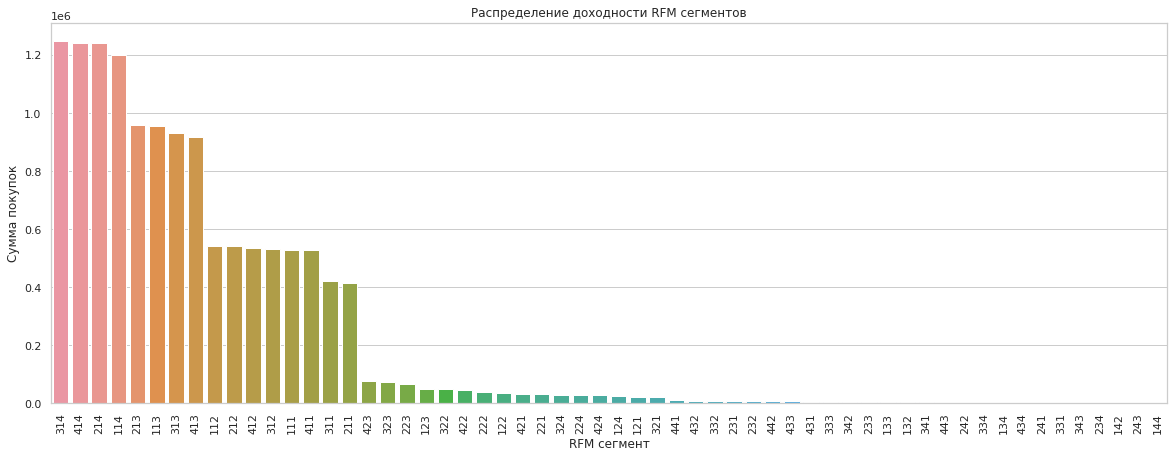

In [220]:
rfm_score_monetary = rfm_df.groupby('rfm_score', as_index=False) \
  .agg({'monetary': 'sum'}).sort_values('monetary', ascending=False)

sns.barplot(data=rfm_score_monetary, x='rfm_score', y='monetary')
plt.xticks(rotation=90)
plt.title('Распределение доходности RFM сегментов')
plt.xlabel('RFM сегмент')
plt.ylabel('Сумма покупок')

Text(0, 0.5, 'Сумма покупок')

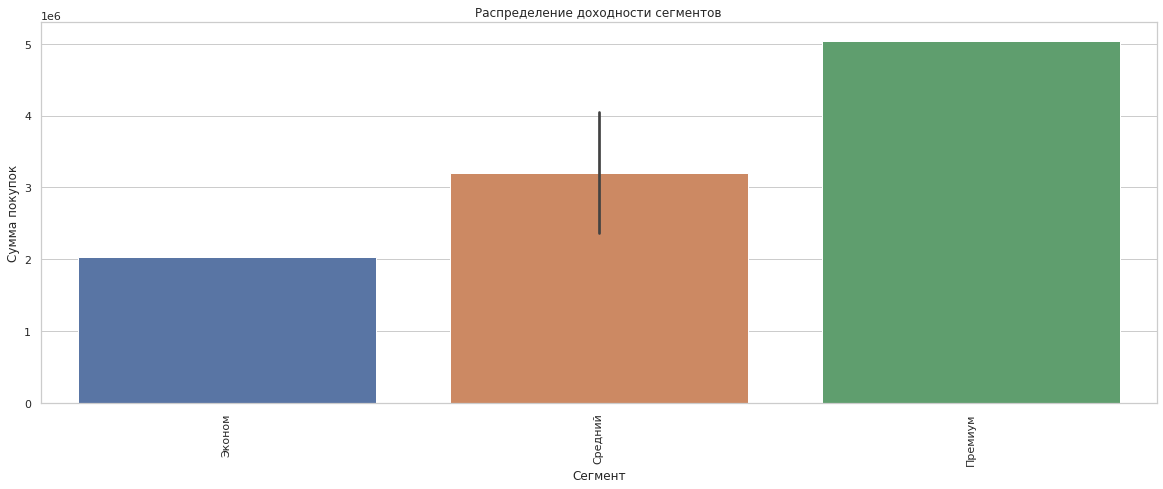

In [224]:
def find_segment(col):
  if col == 1:
    return 'Эконом'
  elif col in [2, 3]:
    return 'Средний'
  else:
    return 'Премиум'

segments_monetary = rfm_df.groupby('m', as_index=False) \
  .agg({'monetary': 'sum'}).rename(columns={'monetary': 'income_sum'})

segments_monetary['segment'] = segments_monetary['m'].apply(lambda x: find_segment(x))
segments_monetary = segments_monetary[['segment', 'income_sum']]

sns.barplot(data=segments_monetary, x='segment', y='income_sum')
plt.xticks(rotation=90)
plt.title('Распределение доходности сегментов')
plt.xlabel('Сегмент')
plt.ylabel('Сумма покупок')

## Вывод

Главная проблема данного торгового предприятия (маркетплейса/интернет-магазина) — это явные проблемы с удержанием потребителей. Большая часть всех покупателей не совершают более 1 покупки.

Кроме того, можно заметить, что крайне не многочисленные клиенты из сегмента "Премиум" занимают первые 4 места по метрике monetary, что в целом может многое сказать о самом бизнесе (ориентирован на опт). Однако, "Премиум" немного уступает в общей сумме "Эконому" и "Среднему".

Главная задача, которую нужно решить — разработка (или улучшение) системы лояльности для дольшего удержания клиентов.

Возможно, проблема в том, что конкуренты предлагают более выгодные условия, поэтому стоит провести конкурентный анализ по ассортименту, цене и сервису.

Кроме того, у компании много потерянных высокодоходных клиентов, которых стоит попытаться вернуть с помощью различных коммерческих предложений.